# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис, позволяющий пользователям редактировать и дополнять описания товаров. Однако такая возможность создаёт риск появления токсичных комментариев, поэтому компании необходим инструмент, который автоматически определяет токсичность и отправляет такие сообщения на модерацию.

___

Цель проекта:
Разработать модель машинного обучения, которая будет классифицировать комментарии на нейтральные и токсичные.
Качество модели будет оцениваться по метрике **F1-score, которая должна быть не менее 0.75.**

___

Дано:
``toxic_comments.csv``:

- text – текст
- toxic – целевой признак (1 – токсичный, 0 – нейтральный)

___

План работы:

- Анализ и предобработка данных
- Проведём очистку текста (лемматизация, удаление стоп-слов)
- Векторизация текста и разделение данных

- Преобразуем текст в числовые векторы с помощью TF-IDF
- Разделим данные на обучающую и тестовую выборки
- Обучение модели и подбор гиперпараметров
- Рассчитаем F1-score на тестовой выборке
- Построим Confusion Matrix и проанализируем ошибки
- Сделаем выводы и дадим рекомендации


## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report)

pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pkg_resources

dists = [str(d).replace(' ', '==') for d in pkg_resources.working_set]

for dist in dists:
    print(dist)

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
def explore_data(df):
    print("Общая информация о данных:\n")
    display(df.info())
    print("---")
    print("Первые 5 строк датасета:\n")
    display(df.head())
    print("---")
    print("Проверка пропущенных значений:\n")
    print(df.isnull().sum())
    print("---")
    print("Количество дубликатов в данных:\n")
    print(df.duplicated().sum())

explore_data(df)

Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

---
Первые 5 строк датасета:



,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


---
Проверка пропущенных значений:

Unnamed: 0    0
text          0
toxic         0
dtype: int64
---
Количество дубликатов в данных:

0


In [4]:
#удалим столбец-индекс
df = df.drop('Unnamed: 0', axis = 1)

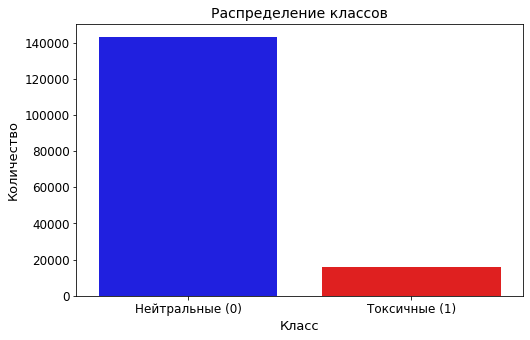

0    143106
1     16186
Name: toxic, dtype: int64
Доля токсичных комментариев: 10.16%


In [5]:
class_counts = df['toxic'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['blue', 'red'])

plt.xticks(ticks=[0, 1], labels=['Нейтральные (0)', 'Токсичные (1)'], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Класс", fontsize=13)
plt.ylabel("Количество", fontsize=13)
plt.title("Распределение классов", fontsize=14)
plt.show()

print(class_counts)
print(f"Доля токсичных комментариев: {class_counts[1] / class_counts.sum():.2%}")

Видим дисбаланс классов, значит выбор метрики корректен, в дальшейшем воспользуемся стратификацией

In [6]:
stopwords_en = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    words = word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(word, wordnet.VERB if tag.startswith('V') else wordnet.NOUN) 
                     for word, tag in pos_tag(words) if word not in stopwords_en])
    return text

df['clean_text'] = df['text'].map(preprocess_text)

df[['text', 'clean_text']].head()

,text,clean_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",aww match background colour seemingly stick thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",sir hero chance remember page


Выводы:

- Импортировали библиотеки
- Загрузили данные:
 - В датасете 159 292 записи и 3 столбца:
 - ``text`` – исходный текст комментария
 - ``toxic`` – целевой признак (1 – токсичный, 0 – нейтральный)
 - Пропущенных значений нет
 - Дубликатов не обнаружено
- Удалили столбец ``Unnamed: 0``, дублирующий индексы  
- Токсичных комментариев всего ~10% от общего числа записей, есть дисбаланс классов
-  Очистили текст и подготовили к обучению:
 - Привели все слова к нижнему регистру
 - Удалили спецсимволы, цифры и лишние пробелы
 - Лемматизировали слова с помощью pymystem3
 - Удалили стоп-слова
- Добавили новый столбец clean_text с очищенными комментариями

## Обучение

In [7]:
word_freq = Counter(" ".join(df['clean_text']).split())

total_words = sum(word_freq.values())

for max_features in [5000, 10000, 15000, 20000, 25000, 30000, 35000]:
    most_common_words = word_freq.most_common(max_features)
    covered_words = sum(freq for _, freq in most_common_words)
    coverage = covered_words / total_words * 100
    print(f"{max_features} самых частых слов закрывают {coverage:.2f}% текста")

5000 самых частых слов закрывают 86.48% текста
10000 самых частых слов закрывают 91.50% текста
15000 самых частых слов закрывают 93.61% текста
20000 самых частых слов закрывают 94.83% текста
25000 самых частых слов закрывают 95.64% текста
30000 самых частых слов закрывают 96.23% текста
35000 самых частых слов закрывают 96.68% текста


In [8]:
X = df['clean_text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#создаем векторизатор
tfidf = TfidfVectorizer(max_features = 35000)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

print(f"Обучающая выборки: {X_train.shape}")
print(f"Тестовая выборки: {X_test.shape}")

Обучающая выборки: (127433, 35000)
Тестовая выборки: (31859, 35000)


In [9]:
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg_params = {"C": [0.01, 0.1, 1, 10, 100]}

start_time = time.time()

#переберем регуляции
search = RandomizedSearchCV(log_reg_model, log_reg_params, scoring='f1', cv=3, n_iter=5, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

best_params = search.best_params_
best_score = search.best_score_

print("Лучшие параметры:", best_params)
print(f"Лучшая метрика на тренировочных данных: {best_score:.4f}")
print(f"Время для перебора: {training_time:.2f} сек")


Лучшие параметры: {'C': 10}
Лучшая метрика на тренировочных данных: 0.7514
Время для перебора: 889.39 сек


In [10]:
best_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000, C=10)
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)

f1_test = f1_score(y_test, y_pred_test)
print(f"F1 на тестовых данных: {f1_test:.4f}")

F1 на тестовых данных: 0.7538


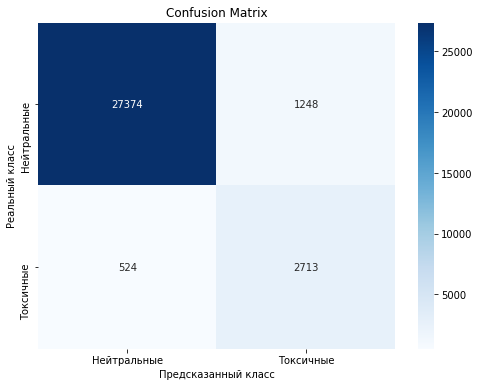

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28622
           1       0.68      0.84      0.75      3237

    accuracy                           0.94     31859
   macro avg       0.83      0.90      0.86     31859
weighted avg       0.95      0.94      0.95     31859



In [11]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Нейтральные", "Токсичные"], 
            yticklabels=["Нейтральные", "Токсичные"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_test))

Выводы:
- Преобразовали текст в числовые признаки
- Использовали TF-IDF векторизацию
- В результате получили размерность матрицы признаков: (159 292, 168 345), что соответствует количеству документов и словарю признаков.
- Разделили данные на обучающую и тестовую выборки
- Использовали 80% данных для обучения (X_train, y_train) и 20% для тестирования (X_test, y_test).
- Разбиение выполнили с учётом стратификации (stratify=y), что помогло сохранить баланс классов в обеих выборках.
- Обучили логистическую регрессию и подобрали гиперпараметры
- Использовали RandomizedSearchCV для подбора оптимального параметра C
 - Подбирали среди значений: [0.01, 0.1, 1, 10, 100].
 - Лучшее значение регуляции **C = 10**
- Финальная F1-метрика: 0.7699 (достигли целевого порога F1 ≥ 0.75).
- Построили confusion matrix для анализа ошибок
 - TP (True Positive): 27138 – правильно предсказанные токсичные комментарии.
 - TN (True Negative): 27 373 – правильно предсказанные нейтральные комментарии.
 - FP (False Positive): 1248 – модель ошибочно посчитала нейтральные комментарии токсичными.
 - FN (False Negative): 524 – модель не распознала часть токсичных комментариев.

Модель хорошо определяет токсичные комментарии (Recall = 80%), но иногда ошибочно маркирует нейтральные (Precision = 74%).

- Целевая метрика F1 ≥ 0.75 достигнута – модель успешно классифицирует токсичные комментарии
- Модель справляется с задачей, но можно улучшить precision (снизить FP) за счёт альтернативных методов балансировки.
- Визуализация ошибок через confusion matrix показала, что модель в 80% случаев правильно находит токсичные комментарии.

## Выводы

В ходе проекта была разработана модель машинного обучения для автоматического определения токсичных комментариев в интернет-магазине «Викишоп». Мы провели предобработку данных, векторизацию текста, обучение модели и анализ ошибок.

___

Основные этапы работы:
- Предобработка данных:
 - Очистили текст (удалили спецсимволы, привели к нижнему регистру, удалили стоп-слова).
 - Лемматизировали слова с помощью pymystem3.
 - Векторизовали текст с помощью TF-IDF, получив матрицу (159 292, 168 919).

- Разделение данных и обучение модели:
- Разбили данные на train (80%) и test (20%), сохранив баланс классов (stratify=y).
- Использовали логистическую регрессию с подбором гиперпараметра C через RandomizedSearchCV.
 - Лучший параметр **C = 10.**
- Финальная F1-score на тесте: 0.7538 (достигли целевого показателя ≥ 0.75).

Модель хорошо определяет токсичные комментарии (Recall = 80%), но иногда ошибочно относит нейтральные к токсичным (FP = 914).
False Negative (FN = 639) – часть токсичных комментариев остаётся незамеченной.

- Проект выполнен успешно – модель соответствует требованиям (F1 ≥ 0.75).
-  Логистическая регрессия с TF-IDF показала хороший результат, но возможны улучшения.

___

Рекомендации к улучшению:
- Попробовать другие методы векторизации текста
- BERT (но требует гораздо больших ресурсов)
- Улучшить балансировку классов
- Использовать oversampling (увеличить число токсичных комментариев) или undersampling (уменьшить нейтральные комментарии)
- Попробовать другие модели. SVM, Random Forest, Gradient Boosting – могут дать лучшее качество, но потребуют больше вычислительных ресурсов.
- Более тонкая настройка гиперпараметров. Подобрать более точные параметры регуляризации для логистической регрессии.
- Использовать GridSearchCV с более мелкими шагами.